## Identify Factors Affecting Housing Rent in Shanghai, China, based On Hedonic Regression and Time Series Prediction

Student Number:20090616

The outlines below:

Chapter 1: Geographic bivariates analysis

Chapter 2: Attributes selecting

Chapter 3: Multi regression model

Chapter 4: K-means Clustering

In [170]:
# SET THE ENVIRONMENT
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
warnings.filterwarnings('ignore') 

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource

pd.set_option('display.max_rows', 300) 
pd.options.display.float_format = '{:40,.4f}'.format
plt.style.use('classic')
%matplotlib inline


# No warming
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

### PART1: GEOGRAPHIC BIVARIATES ANALYSIS

In [121]:
# 1. Read the data
data_q1 = pd.read_csv('GeoResult.csv',engine = 'python')
data_q1.fillna(0,inplace = True)
data_q1.head(5)

,ID,Area,Sum_length,Density,Mean_price,Sum_Z,Mean_cy,Count_trans,POINT_X,POINT_Y
0,3072,2.2500,13.1350,5.8378,"6,155.1200",78943,"4,201.0000",1,"367,888.8330","3,459,075.8110"
1,2032,2.2500,0.0000,0.0000,0.0000,5642,0.0000,2,"319,888.8330","3,438,075.8110"
2,2469,2.2500,9.1874,4.0833,0.0000,25194,0.0000,1,"327,388.8330","3,447,075.8110"
3,2474,2.2500,5.4484,2.4215,0.0000,683,0.0000,1,"334,888.8330","3,447,075.8110"
4,1706,2.2500,1.5197,0.6754,0.0000,2774,0.0000,7,"370,888.8330","3,430,575.8110"


In [122]:
# 2.Standardization of indicators

def f1(data,col):
    return (data[col]-data[col].min())/(data[col].max()-data[col].min())
# Set the function (f)，and calculate the distance to city centre

data_q1['Population'] = f1(data_q1,'Sum_Z')
data_q1['Road_density'] = f1(data_q1,'Density')
data_q1['Commercial_price'] = f1(data_q1,'Mean_cy')
data_q1['Transportation'] = f1(data_q1,'Count_trans')*100
data_q1['Distance'] = ((data_q1['POINT_X'] - 353508.848122)**2 + (data_q1['POINT_Y']-3456140.926976)**2)**0.5

data_q1_test = data_q1[['Population','Road_density','Commercial_price','Mean_price','Transportation','Distance']]
data_q1_test = data_q1_test[data_q1_test['Mean_price']>0].reset_index() # delet the data with 0
del data_q1_test['index']
data_q1_test.head(10)

,Population,Road_density,Commercial_price,Mean_price,Transportation,Distance
0,0.2055,0.1447,0.0436,"6,155.1200",1.3889,"14,676.4270"
1,0.2821,0.1040,0.1837,"10,497.5000",2.7778,"9,171.6860"
2,0.5157,0.2081,0.6789,"9,020.1900",2.7778,"3,778.6072"
3,0.0648,0.0900,0.0000,"4,047.7000",0.0000,"15,698.1131"
4,0.0995,0.1439,0.0000,"2,233.3300",0.0000,"55,518.4793"
5,0.4318,0.1218,0.7957,"6,973.6200",0.0000,"7,479.8219"
6,0.2238,0.0214,0.0000,"4,651.3300",0.0000,"14,583.0588"
7,0.0510,0.0804,0.0000,"3,150.0000",0.0000,"53,728.4483"
8,0.0046,0.0741,0.0000,"4,833.3300",0.0000,"10,601.7003"
9,0.1963,0.1145,0.0000,"6,136.1600",0.0000,"9,746.5009"


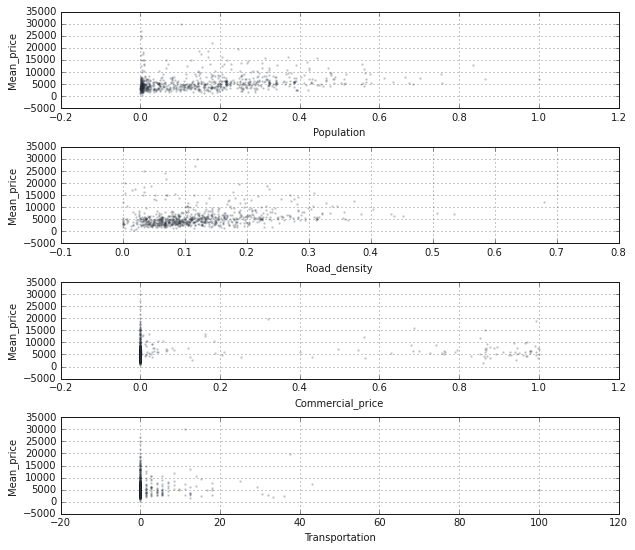

In [123]:
# 3. Check the relativity

fig = plt.figure(figsize = (10,9))
plt.subplots_adjust(hspace=0.4)

# Set the plot
ax1 = fig.add_subplot(4,1,1)
ax1.scatter(data_q1_test['Population'], data_q1_test['Mean_price'],s = 2,alpha = 0.2)
plt.xlabel('Population')
plt.ylabel('Mean_price')
plt.grid()
# Scatter FIG. 1 → Population density index - average price per square meter of housing

ax2 = fig.add_subplot(4,1,2)
ax2.scatter(data_q1_test['Road_density'], data_q1_test['Mean_price'],s = 2,alpha = 0.2)
plt.xlabel('Road_density')
plt.ylabel('Mean_price')
plt.grid()

# Scatter FIG. 2 → Road network density index - average price per square meter of housing

ax3 = fig.add_subplot(4,1,3)
ax3.scatter(data_q1_test['Commercial_price'], data_q1_test['Mean_price'],s = 2,alpha = 0.2)
plt.xlabel('Commercial_price')
plt.ylabel('Mean_price')
plt.grid()

# Scatter FIG. 3 → Food and beverage price index - average price per square meter of housing

ax3 = fig.add_subplot(4,1,4)
ax3.scatter(data_q1_test['Transportation'], data_q1_test['Mean_price'],s = 2,alpha = 0.2)
plt.xlabel('Transportation')
plt.ylabel('Mean_price')
plt.grid()

# Scatter FIG. 4 → catering price index - average price of housing per square meter

Population                                           0.2129
Road_density                                         0.2327
Commercial_price                                     0.1114
Mean_price                                           1.0000
Transportation                                       0.0370
Distance                                            -0.3672
Name: Mean_price, dtype: float64

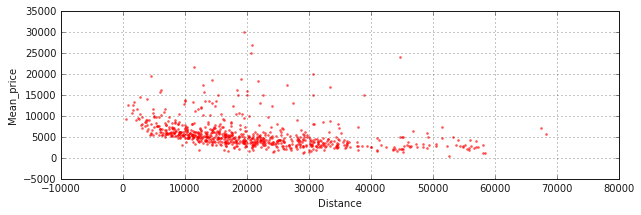

In [124]:
# 4.Check the "average price per square meter" and distance from the city center
fig = plt.figure(figsize = (10,3))

data_q1_test2 = data_q1_test.sort_values('Distance')
plt.scatter(data_q1_test2['Distance'], data_q1_test2['Mean_price'],color = 'red',s = 3,alpha = 0.5)
plt.xlabel('Distance')
plt.ylabel('Mean_price')
plt.grid()
# Scatter FIG. 4 → Distance from the city center - average price per square meter of housing

data_q1_test.corr().loc['Mean_price']

### PART2: ATTRIBUTES SELECTING

2.1 Read the datasets and remove the 'NA' data and outlier data.

In [164]:
import os
os.chdir('D:/CASA-Dissertation/dissertation/')

path = os.getcwd()
df01 = pd.read_csv(path + '/HouserentSH.csv',low_memory=False)
df01.head()

,FID,Price,Unit_price,Size,Room_number,Decoration,Rent_type,Income,Region,Resource,Longtitude,Latitude,Distance
0,1,6000,144.0200,41.6600,1,Simplified,Wholely,6620,Pudong,third,121.4992,31.1738,7.5151
1,2,4200,111.2600,37.7500,1,Simplified,Wholely,4700,Yangpu,third,121.5480,31.3221,12.2910
2,3,6000,91.3900,65.6500,2,Simplified,Wholely,5700,Xuhui,third,121.4615,31.1981,4.2047
3,4,4500,72.5700,62.0100,2,Simplified,Wholely,5450,Baoshan,third,121.4916,31.3449,12.3277
4,5,6000,151.5200,39.6000,2,Simplified,Wholely,4700,Yangpu,third,121.5286,31.2683,6.8827


In [165]:
df01.dtypes

FID              int64
Price            int64
Unit_price     float64
Size           float64
Room_number      int64
Decoration      object
Rent_type       object
Income           int64
Region          object
Resource        object
Longtitude     float64
Latitude       float64
Distance       float64
dtype: object

In [166]:
df01 = df01[['FID','Price','Unit_price','Size','Room_number','Decoration','Rent_type','Region','Resource','Income','Longtitude','Latitude']]
df01.head(5)

,FID,Price,Unit_price,Size,Room_number,Decoration,Rent_type,Region,Resource,Income,Longtitude,Latitude
0,1,6000,144.0200,41.6600,1,Simplified,Wholely,Pudong,third,6620,121.4992,31.1738
1,2,4200,111.2600,37.7500,1,Simplified,Wholely,Yangpu,third,4700,121.5480,31.3221
2,3,6000,91.3900,65.6500,2,Simplified,Wholely,Xuhui,third,5700,121.4615,31.1981
3,4,4500,72.5700,62.0100,2,Simplified,Wholely,Baoshan,third,5450,121.4916,31.3449
4,5,6000,151.5200,39.6000,2,Simplified,Wholely,Yangpu,third,4700,121.5286,31.2683


In [167]:
print('The number of data is %i.' % len(df01))

The number of data is 43673.


2.2 Check outliners according to the unit rent and size.The count of data was deleted from 43,673 to 41,151. Generally, over the 1% of the original data should be reserved.However, the 2,522 is less than 4,367 comparing with the huge base data . Thus the outliers are suggested to be cleared.

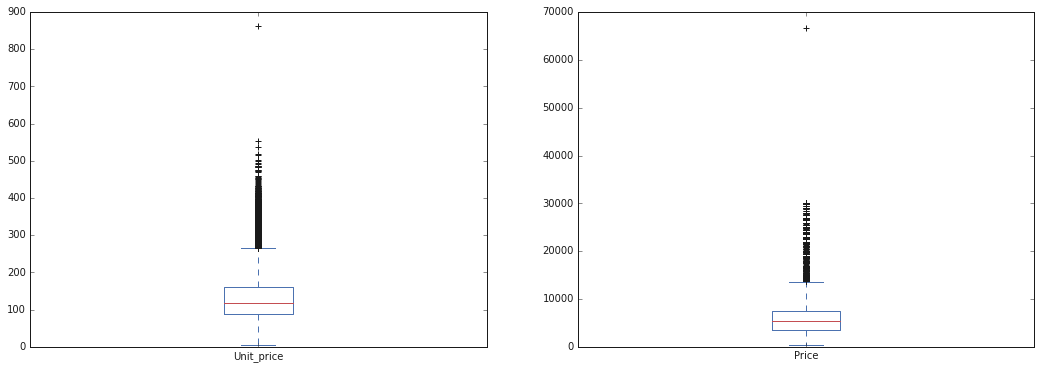

In [171]:
fig,ax = plt.subplots(1,2,figsize = (18,6))
df01['Unit_price'].plot.box(ax = ax[0])
df01['Price'].plot.box(ax = ax[1])
plt.show()

In [172]:
def get_norm(data, col):
    q1 = data[col].quantile(q = 0.25)
    q3 = data[col].quantile(q = 0.75)
    iqr = q3 - q1
    t1 = q1 - 1.5*iqr
    t2 = q3 + 1.5*iqr
    return data[(data[col]>t1) & (data[col]<t2)]

df_original = df01
df02 = get_norm(df01, 'Unit_price')
df = get_norm(df02, 'Size')
df.describe()

,FID,Price,Unit_price,Size,Room_number,Income,Longtitude,Latitude
count,"41,151.0000","41,151.0000","41,151.0000","41,151.0000","41,151.0000","41,151.0000","41,151.0000","41,151.0000"
mean,"21,389.4952","6,481.0631",123.8754,60.7873,2.1717,"6,209.8564",121.4562,31.2147
std,"12,500.1352","4,223.1394",50.6834,36.8110,1.0047,"1,796.3862",0.1070,0.0994
min,1.0000,500.0000,5.5200,5.5000,1.0000,"4,240.0000",120.9309,30.7177
25%,"10,622.5000","3,830.0000",87.6950,34.3900,1.0000,"5,170.0000",121.4014,31.1614
50%,"21,246.0000","5,600.0000",116.8200,55.1400,2.0000,"5,700.0000",121.4499,31.2208
75%,"31,780.5000","7,500.0000",154.3300,86.0000,3.0000,"6,620.0000",121.5204,31.2729
max,"43,828.0000","30,000.0000",267.0100,167.6800,9.0000,"11,930.0000",121.9312,31.8356


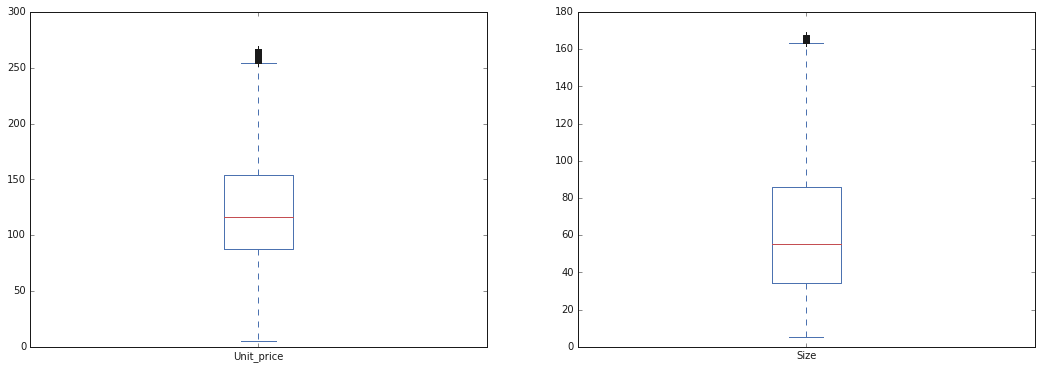

In [173]:
fig,ax = plt.subplots(1,2,figsize = (18,6))
df['Unit_price'].plot.box(ax = ax[0])
df['Size'].plot.box(ax = ax[1])
plt.show()

In [174]:
print('The acount of data is %i' % len(df))
df.to_csv(path + '/HouserentSHNew.csv')

The acount of data is 41151


2.3 Read data afer connecting geographic with arcgis pro.As thecommercial price and transportation stations counts of each  grid is sparse, to ensure the stability of model, these two varialbles are excluded.

In [175]:
dfnew = pd.read_csv(path + '/HouserentSHNew3.csv',low_memory=False)
dfnew.head(5)

# delete population = 0
data_q3_test = dfnew[dfnew['Sum_Z']>0].reset_index()
del data_q3_test['index']
data_q3_test.head(10)
print('The acount of data is %i' % len(data_q3_test))
# delete rhe density = 0
data_q3_test2 = data_q3_test[data_q3_test['Density']>0].reset_index()
del data_q3_test2['index']
data_q3_test2.head(10)
print('The acount of data is %i' % len(data_q3_test2))
dfnew=data_q3_test2

dfnew

The acount of data is 41104
The acount of data is 40954


,Unnamed: 0,X,FID,Price,Unit_price,Size,Room_number,Decoration,Rent_type,Income,...,Latitude,Distance,ID,Area,Sum_length,Density,Mean_price,Sum_Z,POINT_X,POINT_Y
0,1,0,1,6000,144.0200,41.6600,1,Simplified,Wholely,6620,...,31.1738,7.5151,2633,2.2500,13.5197,6.0087,"5,939.4500",148390,"357,388.8330","3,450,075.8110"
1,2,1,2,4200,111.2600,37.7500,1,Simplified,Wholely,4700,...,31.3221,12.2910,3428,2.2500,6.6621,2.9609,"5,017.7700",61252,"361,888.8330","3,466,575.8110"
2,3,2,3,6000,91.3900,65.6500,2,Simplified,Wholely,5700,...,31.1981,4.2047,2774,2.2500,15.8213,7.0317,"9,679.1900",145533,"352,888.8330","3,453,075.8110"
3,4,3,4,4500,72.5700,62.0100,2,Simplified,Wholely,5450,...,31.3449,12.3277,3496,2.2500,20.3867,9.0608,"5,073.3700",99759,"355,888.8330","3,468,075.8110"
4,5,4,5,6000,151.5200,39.6000,2,Simplified,Wholely,4700,...,31.2683,6.8827,3139,2.2500,15.2496,6.7776,"6,239.1700",117129,"360,388.8330","3,460,575.8110"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40949,41147,43668,43824,2460,201.1400,12.2300,3,Simplified,Partly,5700,...,31.1997,4.5370,2773,2.2500,19.4356,8.6380,"8,635.4700",184206,"351,388.8330","3,453,075.8110"
40950,41148,43669,43825,2390,177.0400,13.5000,3,Simplified,Partly,5700,...,31.1997,4.5370,2773,2.2500,19.4356,8.6380,"8,635.4700",184206,"351,388.8330","3,453,075.8110"
40951,41149,43670,43826,5460,114.0100,47.8900,2,Simplified,Wholely,5700,...,31.1981,4.7073,2773,2.2500,19.4356,8.6380,"8,635.4700",184206,"351,388.8330","3,453,075.8110"
40952,41150,43671,43827,2330,167.7500,13.8900,3,Simplified,Partly,5700,...,31.1997,4.5370,2773,2.2500,19.4356,8.6380,"8,635.4700",184206,"351,388.8330","3,453,075.8110"


2.4 Set the base font and color. Making the bivariate plot, using broken line diagram, scatter diagram, bar diagram to visualise these relations.

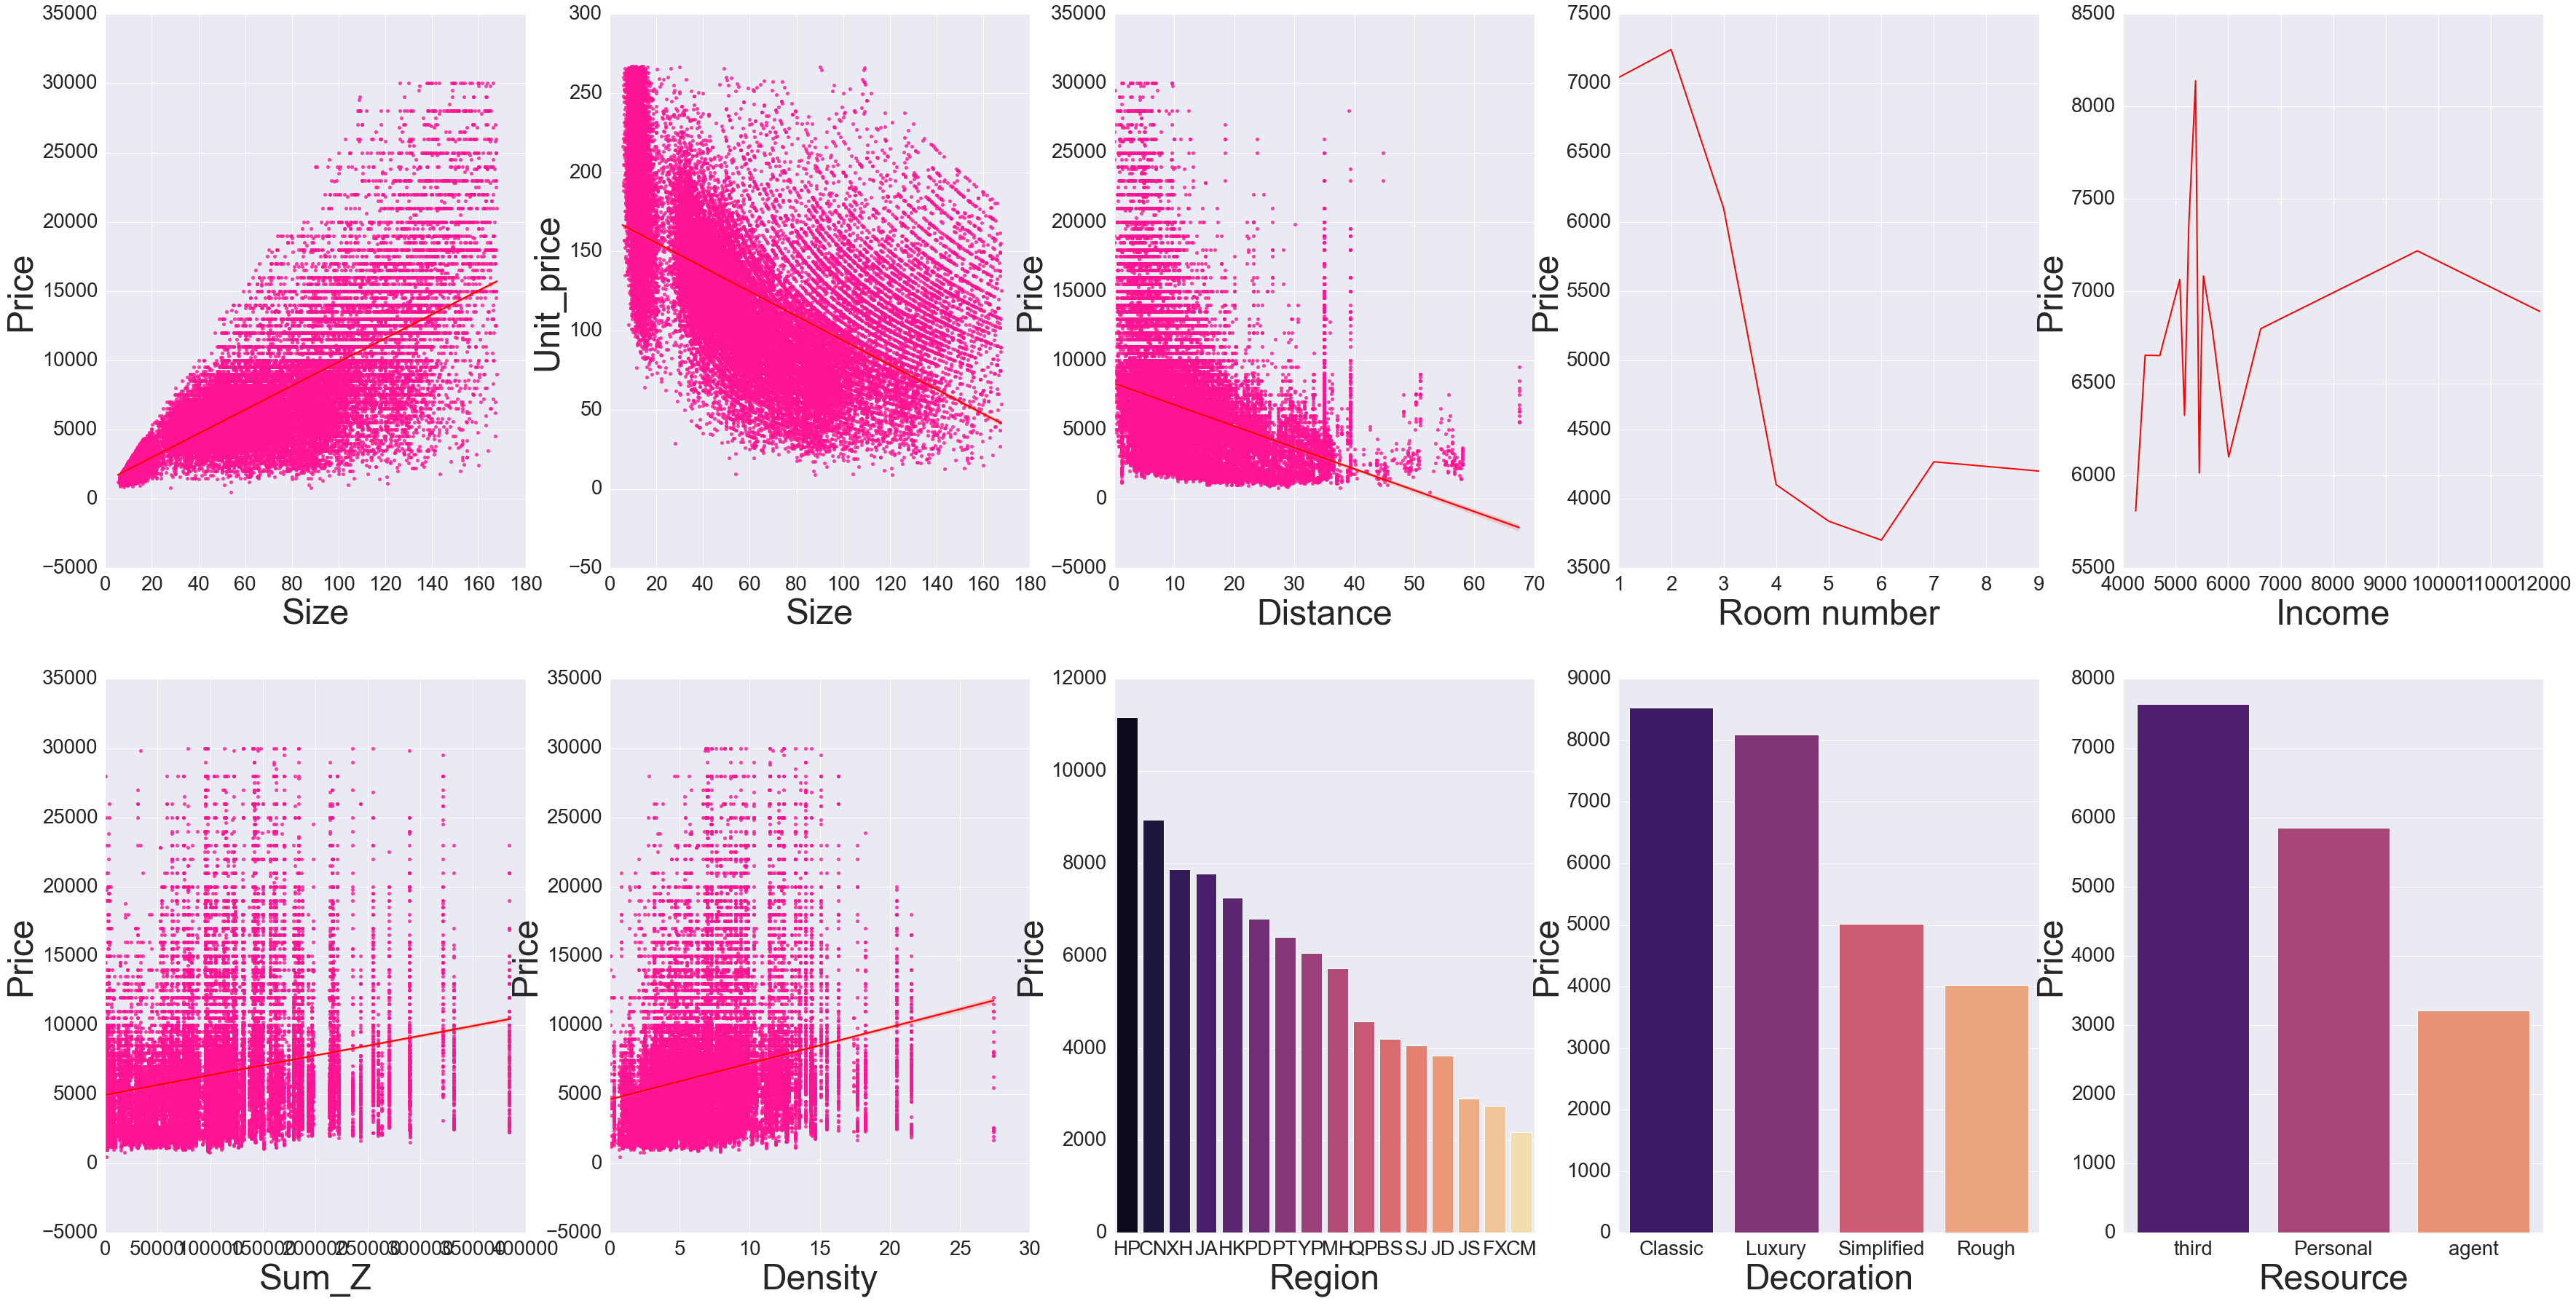

In [176]:
# Setting the base font and color.
font_size = 30
color_base = "magma"
sns.set(font_scale = 2.5)

# Fig 1. bivariate plots between dependent and independent variables
f2,axes = plt.subplots(2, 5, figsize=(60,30))

# size
sns.regplot(x='Size', y='Price', data=dfnew, ax=axes[0,0], scatter_kws={"color": "deeppink"}, line_kws={"color": "red"})
axes[0,0].set_xlabel('Size', fontsize=font_size*1.6)
axes[0,0].set_ylabel('Price', fontsize=font_size*1.6)
# unit_price-size
sns.regplot(x='Size', y='Unit_price', data=dfnew, ax=axes[0,1], scatter_kws={"color": "deeppink"}, line_kws={"color": "red"})
axes[0,1].set_xlabel('Size', fontsize=font_size*1.6)
axes[0,1].set_ylabel('Unit_price', fontsize=font_size*1.6)
# distance
sns.regplot(x='Distance', y='Price', data=dfnew, ax=axes[0,2], scatter_kws={"color": "deeppink"}, line_kws={"color": "red"})
axes[0,2].set_xlabel('Distance', fontsize=font_size*1.6)
axes[0,2].set_ylabel('Price', fontsize=font_size*1.6)
# room
df.groupby(dfnew['Room_number'])['Price'].mean().plot(color='red',linewidth=2.0,linestyle='-',ax=axes[0,3])
axes[0,3].set_xlabel('Room number', fontsize=font_size*1.6)
axes[0,3].set_ylabel('Price', fontsize=font_size*1.6)
# income
df.groupby(dfnew['Income'])['Price'].mean().plot(color='red',linewidth=2.0,linestyle='-',ax=axes[0,4])
axes[0,4].set_xlabel('Income', fontsize=font_size*1.6)
axes[0,4].set_ylabel('Price', fontsize=font_size*1.6)
# Sum_Z
sns.regplot(x='Sum_Z', y='Price', data=dfnew, ax=axes[1,0], scatter_kws={"color": "deeppink"}, line_kws={"color": "red"})
axes[1,0].set_xlabel('Sum_Z', fontsize=font_size*1.6)
axes[1,0].set_ylabel('Price', fontsize=font_size*1.6)
# decoration
df_ReMean_Price = dfnew.groupby('Decoration')['Price'].mean().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(x='Decoration', y='Price', palette=color_base, data=df_ReMean_Price, ax=axes[1,3])
axes[1,3].set_xlabel('Decoration', fontsize=font_size*1.6)
axes[1,3].set_ylabel('Price', fontsize=font_size*1.6)
# Density
sns.regplot(x='Density', y='Price', data=dfnew, ax=axes[1,1], scatter_kws={"color": "deeppink"}, line_kws={"color": "red"})
axes[1,1].set_xlabel('Density', fontsize=font_size*1.6)
axes[1,1].set_ylabel('Price', fontsize=font_size*1.6)
# district
Reagion_abbreviation = { 'Huangpu': 'HP', 'Jingan': 'JA', 'Changning': 'CN', 'Hongkou': 'HK', 'Xuhui': 'XH', 'Yangpu': 'YP', 'Putuo': 'PT', 'Minhang': 'MH', 'Pudong': 'PD', 'Baoshan': 'BS', 'Jiading': 'JD', 'Songjiang': 'SJ', 'Qingpu': 'QP', 'Fengxian': 'FX', 'Jinshan': 'JS', 'Chongming':'CM'}
#dfnew = copy.deepcopy(df0)
dfnew['Region'] = dfnew['Region'].apply(lambda x : Reagion_abbreviation[x])
df_house_mean = dfnew.groupby('Region')['Price'].mean().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(x='Region', y='Price', palette=color_base, data=df_house_mean, ax=axes[1,2])
axes[1,2].set_xlabel('Region', fontsize=font_size*1.6)
axes[1,2].set_ylabel('Price', fontsize=font_size*1.6)
# resource
df_TaMean_Price = dfnew.groupby('Resource')['Price'].mean().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(x='Resource', y='Price', palette=color_base, data=df_TaMean_Price, ax=axes[1,4])
axes[1,4].set_xlabel('Resource', fontsize=font_size*1.6)
axes[1,4].set_ylabel('Price', fontsize=font_size*1.6)

# f2.delaxes(ax= axes[1,5])

plt.savefig('./Fig.5.Bivariate plots between dependent and independent variables.jpg')
plt.show()

2.5 From the diagrams above, drop the factor-resources, and according to the category factor-decoration, define the degreee of the decoration.After that, making the heatmap for each independent variables.

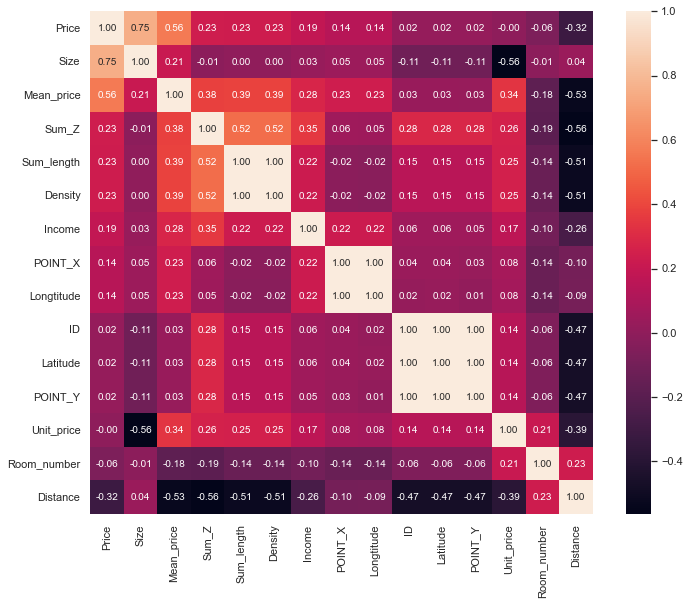

In [178]:
# Fig 2.Heatmap of each independent variables
corr = dfnew.corr()
k=15
cols = corr.nlargest(k, 'Price')['Price'].index
heat = np.corrcoef(dfnew[cols].values.T)
sns.set(font_scale=1)
plt.subplots(figsize=(12, 9))
hm = sns.heatmap(heat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.savefig('./Fig.2.Heatmap of each independent variables.jpg')
plt.show()

2.6 Make the VIF to test the degree of multipulities.The VIFs for all the independent variables are under 5,there's a low multipulities.

In [179]:
y, X = dmatrices('Price~ Size+ Room_number+ Income+ Decoration', data = dfnew, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,24.8163,Intercept
1,1.0015,Decoration[T.Luxury]
2,1.0112,Decoration[T.Rough]
3,1.2881,Decoration[T.Simplified]
4,1.2244,Size
5,1.0576,Room_number
6,1.0126,Income


### PART 3: MULTI REGRESSION MODEL

3.1 Firstly, make a simple multi regression model to test the values of R-squared, Skew, and Kurtosis. From the model1, the Skew(1.207) and Kurtosis (9.882) show it's similar to the normaliazation distribution.

In [180]:
multi_regression_model_1 = smf.ols(formula='Price ~ Size+ Room_number+ Income+ Decoration+ Resource + Region',data=dfnew).fit()

print(multi_regression_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     4739.
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:11:34   Log-Likelihood:            -3.7413e+05
No. Observations:               40954   AIC:                         7.483e+05
Df Residuals:                   40931   BIC:                         7.485e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Loading BokehJS ...

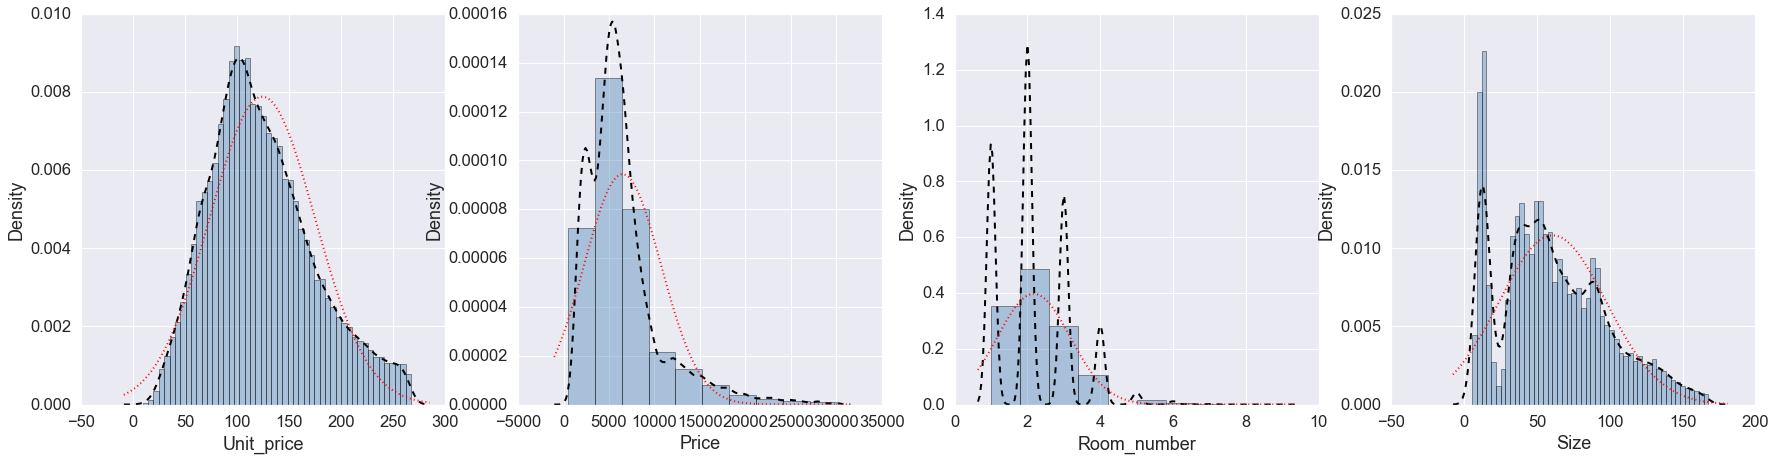

In [181]:
# No warning
from bokeh.io import output_notebook
output_notebook()

# Fig 3. Distribution histograms for independent variables.
df=dfnew
sns.set(font_scale = 1.5)
f4, [ax1, ax2, ax3, ax4] = plt.subplots(1,4, figsize=(30, 7))
# Unit rent price
sns.distplot(a=df.Unit_price, fit=stats.norm, norm_hist=True, ax=ax1, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# Size
sns.distplot(a=df.Size, fit=stats.norm, norm_hist=True, ax=ax4, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# Room_number
sns.distplot(a=df.Room_number, bins=10, fit=stats.norm, norm_hist=True, ax=ax3, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# Price
sns.distplot(a=df.Price, bins=10, fit=stats.norm, norm_hist=True, ax=ax2, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
plt.savefig('./Fig.3.Distribution histograms for independent variables.jpg')
plt.show()

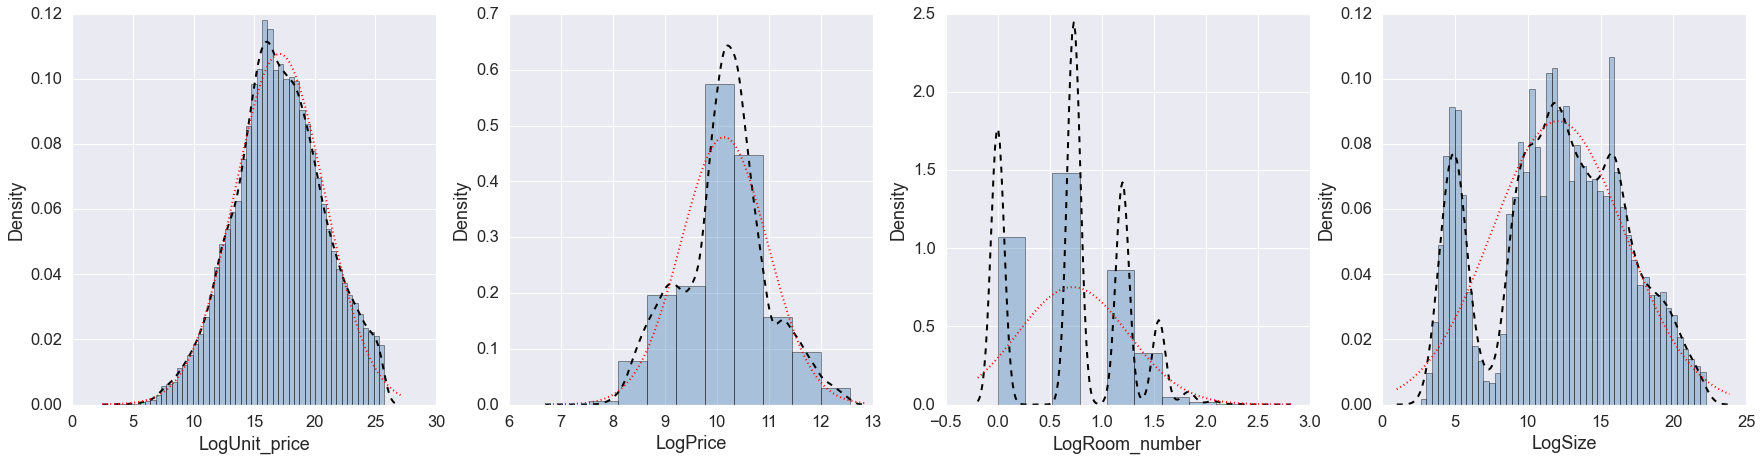

In [182]:
# Perform log transformation for Unit rent price, Size，Room number, Income and Decoration degree.
df['LogUnit_price'],lambda_=stats.boxcox(df.Unit_price)
df['LogSize'],lambda_=stats.boxcox(df.Size)
df['LogRoom_number'],lambda_=stats.boxcox(df.Room_number)
df['LogPrice'],lambda_=stats.boxcox(df.Price)
df['LogIncome'],lambda_=stats.boxcox(df.Income)
df['LogDistance'],lambda_=stats.boxcox(df.Distance)


# Fig 4. Distribution histograms for  Unit rent price, Size，Room number,and Distance after log transformation.
f4, [ax1, ax2, ax3, ax4] = plt.subplots(1,4, figsize=(30, 7))
# Unit rent price
sns.distplot(a=df.LogUnit_price, fit=stats.norm, norm_hist=True, ax=ax1, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# Size
sns.distplot(a=df.LogSize, fit=stats.norm, norm_hist=True, ax=ax4, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# Room_number
sns.distplot(a=df.LogRoom_number, bins=10, fit=stats.norm, norm_hist=True, ax=ax3, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# Price
sns.distplot(a=df.LogPrice, bins=10, fit=stats.norm, norm_hist=True, ax=ax2, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})

plt.savefig('./Fig 4.Distribution histograms for  Unit rent price, Size，Room number,and Distance after log transformation..jpg')
plt.show()

sns.set(font_scale = 1)

3.2  Make the Multi regression model after log transformation. And test the R-squared value by deleting each factor. From the first model, adjust the dependent variable like logtransformation to test the multi regression models. 

In [183]:
multi_regression_model_2 = smf.ols(formula='LogPrice ~ LogSize+ LogIncome+ Decoration+ Region+ Resource+LogRoom_number',data=df).fit()

print(multi_regression_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     9159.
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:12:18   Log-Likelihood:                -14193.
No. Observations:               40954   AIC:                         2.843e+04
Df Residuals:                   40931   BIC:                         2.863e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [155]:
# delete room number
multi_regression_model_3 = smf.ols(formula='LogPrice ~ LogSize+ LogIncome+ Decoration+ Region+ Resource',data=df).fit()

print(multi_regression_model_3.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     9519.
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:06:09   Log-Likelihood:                -14597.
No. Observations:               41151   AIC:                         2.924e+04
Df Residuals:                   41129   BIC:                         2.943e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [156]:
# delete income
multi_regression_model_4 = smf.ols(formula='LogPrice ~ LogSize+ Decoration+ Region+ Resource+LogRoom_number',data=df).fit()

print(multi_regression_model_4.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     9178.
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:06:45   Log-Likelihood:                -14425.
No. Observations:               41151   AIC:                         2.890e+04
Df Residuals:                   41128   BIC:                         2.909e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [157]:
# delete resource
multi_regression_model_5 = smf.ols(formula='LogPrice ~ LogSize+ Decoration+ LogIncome+ Region+LogRoom_number',data=df).fit()

print(multi_regression_model_5.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     9923.
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:07:24   Log-Likelihood:                -14720.
No. Observations:               41151   AIC:                         2.948e+04
Df Residuals:                   41130   BIC:                         2.966e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [158]:
#delet decoration
multi_regression_model_6 = smf.ols(formula='LogPrice ~ LogSize+ Resource+LogIncome+ Region+LogRoom_number',data=df).fit()

print(multi_regression_model_6.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     9715.
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:08:06   Log-Likelihood:                -15949.
No. Observations:               41151   AIC:                         3.194e+04
Df Residuals:                   41131   BIC:                         3.211e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.3419      0.01

In [159]:
#delete region
multi_regression_model_7 = smf.ols(formula='LogPrice ~ LogSize+ Resource+LogIncome+ Decoration+LogRoom_number',data=df).fit()

print(multi_regression_model_7.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                 1.293e+04
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:08:30   Log-Likelihood:                -25120.
No. Observations:               41151   AIC:                         5.026e+04
Df Residuals:                   41142   BIC:                         5.034e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

3.3 Combine the geographic attributes inclusing the population, the road density, the distance to the city centre.

Loading BokehJS ...

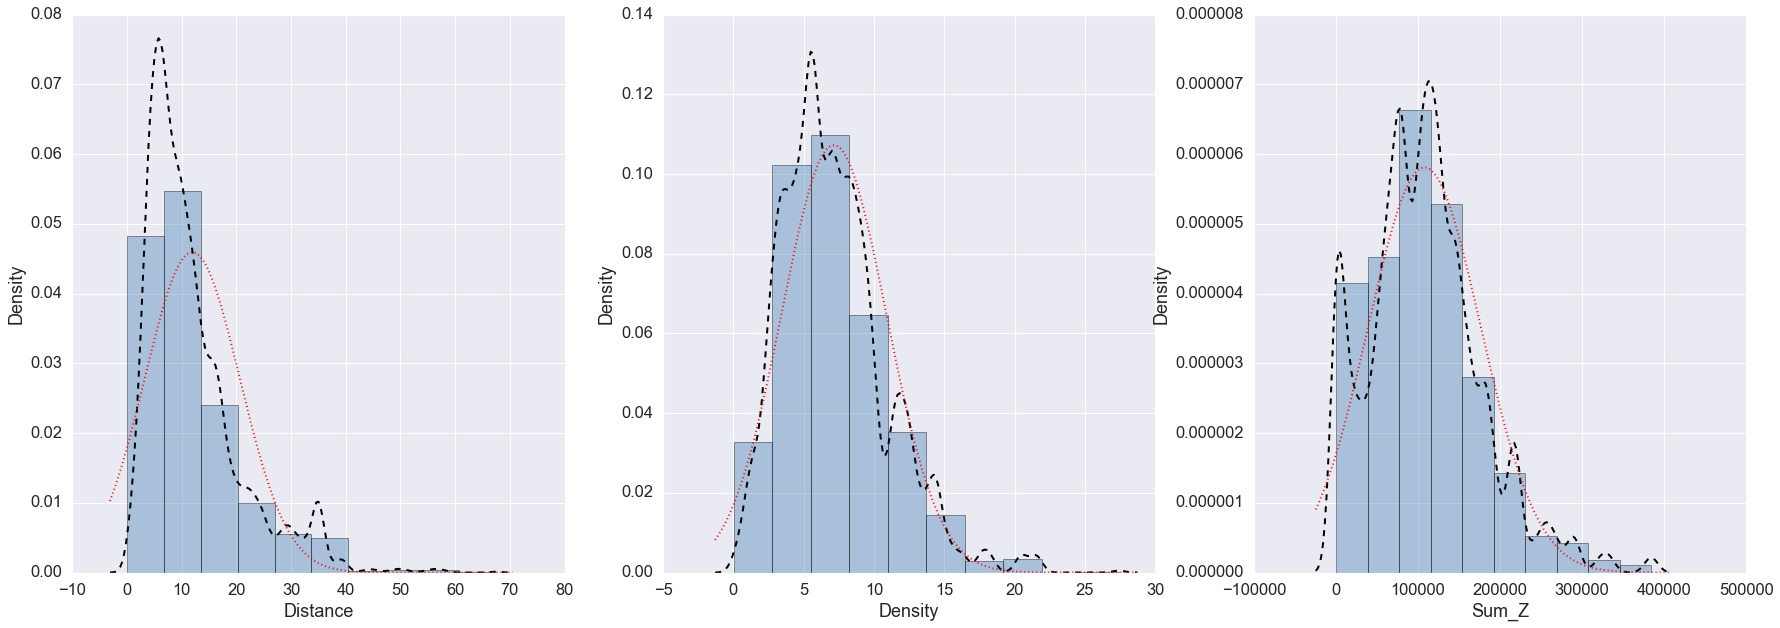

In [185]:
# 不发出警告
from bokeh.io import output_notebook
output_notebook()

# Fig 3. Distribution histograms for independent variables.
sns.set(font_scale = 1.5)
f4, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(30, 10))

# Distance
sns.distplot(a=df.Distance, bins=10, fit=stats.norm, norm_hist=True, ax=ax1, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# Density
sns.distplot(a=df.Density, bins=10, fit=stats.norm, norm_hist=True, ax=ax2, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# Sum_Z
sns.distplot(a=df.Sum_Z, bins=10, fit=stats.norm, norm_hist=True,  ax=ax3, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})


plt.savefig('./Fig.5.Distribution histograms for independent variables.jpg')
plt.show()

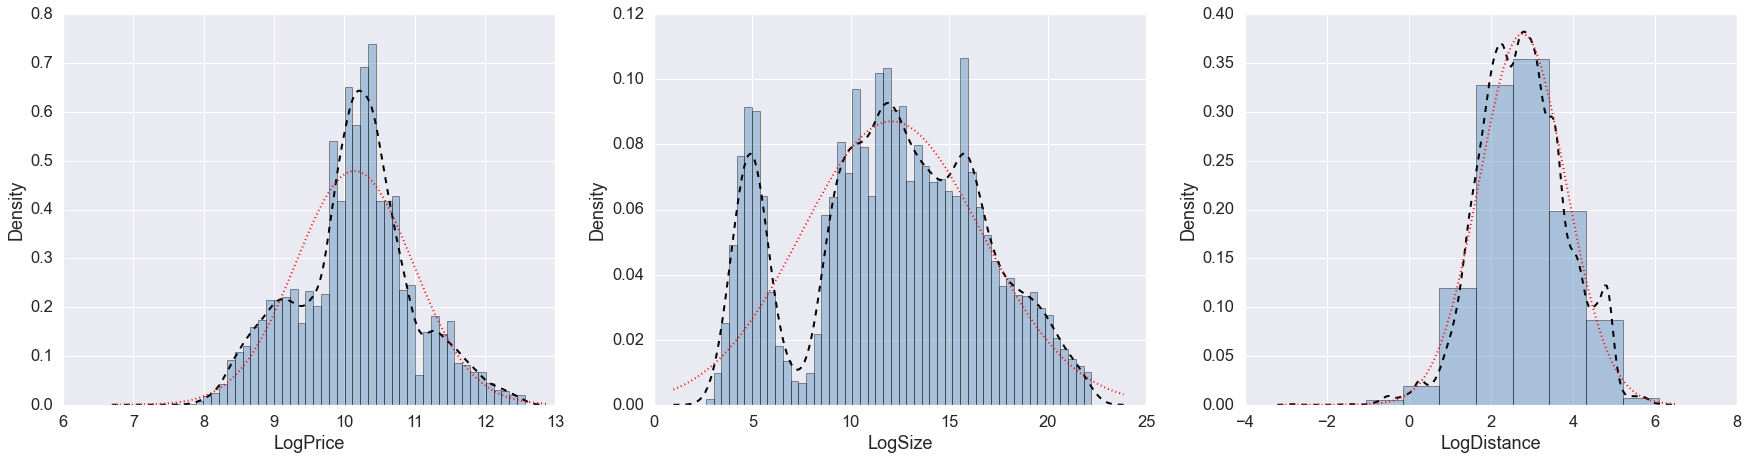

In [187]:
dfnew['LogDistance'],lambda_=stats.boxcox(df.Distance)
dfnew['LogSum_Z'],lambda_=stats.boxcox(df.Sum_Z)
dfnew['LogDensity'],lambda_=stats.boxcox(df.Density)

f4, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(30, 7))
# Price
sns.distplot(a=dfnew.LogPrice, fit=stats.norm, norm_hist=True, ax=ax1, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# Size
sns.distplot(a=dfnew.LogSize, fit=stats.norm, norm_hist=True, ax=ax2, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})

# Distance
sns.distplot(a=dfnew.LogDistance, bins=10, fit=stats.norm, norm_hist=True, ax=ax3, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})

plt.savefig('./Fig.6.Distribution histograms for independent variables.jpg')
plt.show()

In [208]:
y, X = dmatrices('LogPrice~ Income+LogSize+ LogDistance+ LogDensity+ LogSum_Z+LogRoom_number', data = dfnew, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,81.2144,Intercept
1,1.2031,Income
2,1.0037,LogSize
3,2.3367,LogDistance
4,1.7171,LogDensity
5,1.9028,LogSum_Z
6,1.0787,LogRoom_number


In [209]:
# model as the former, all
multi_regression_model_01 = smf.ols(formula='LogPrice ~ LogSize+ Decoration+ +Region + Resource+ LogDistance+ LogDensity+ LogSum_Z+LogRoom_number',data=dfnew).fit()

print(multi_regression_model_01.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                 1.133e+04
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        21:20:07   Log-Likelihood:                -8234.2
No. Observations:               40954   AIC:                         1.652e+04
Df Residuals:                   40928   BIC:                         1.674e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [205]:
# model as the former, all
multi_regression_model_03 = smf.ols(formula='LogPrice ~ LogSize+ Decoration+ +Region + Resource+ LogDistance+ LogDensity+ LogRoom_number',data=dfnew).fit()

print(multi_regression_model_03.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 1.171e+04
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        21:11:50   Log-Likelihood:                -8386.0
No. Observations:               40954   AIC:                         1.682e+04
Df Residuals:                   40929   BIC:                         1.704e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [206]:
# model as the former, all
multi_regression_model_04 = smf.ols(formula='LogPrice ~ LogSize+ Decoration+ +Region + Resource+ LogDistance+ LogDensity',data=dfnew).fit()

print(multi_regression_model_04.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                 1.218e+04
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        21:13:59   Log-Likelihood:                -8447.3
No. Observations:               40954   AIC:                         1.694e+04
Df Residuals:                   40930   BIC:                         1.715e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [210]:
# model as the former, all
multi_regression_model_03 = smf.ols(formula='LogPrice ~ LogSize+ Decoration+ +Region + Resource+ LogDistance+ LogDensity+ LogSum_Z',data=dfnew).fit()

print(multi_regression_model_03.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 1.177e+04
Date:                Sun, 28 Aug 2022   Prob (F-statistic):               0.00
Time:                        21:21:31   Log-Likelihood:                -8291.2
No. Observations:               40954   AIC:                         1.663e+04
Df Residuals:                   40929   BIC:                         1.685e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

3.4 Meke the Residual Scatter diagram. It shows almost the vertical bars are centered near zero and spread symmetrically in each direction, indicating constant variance and near zero mean for residuals. 

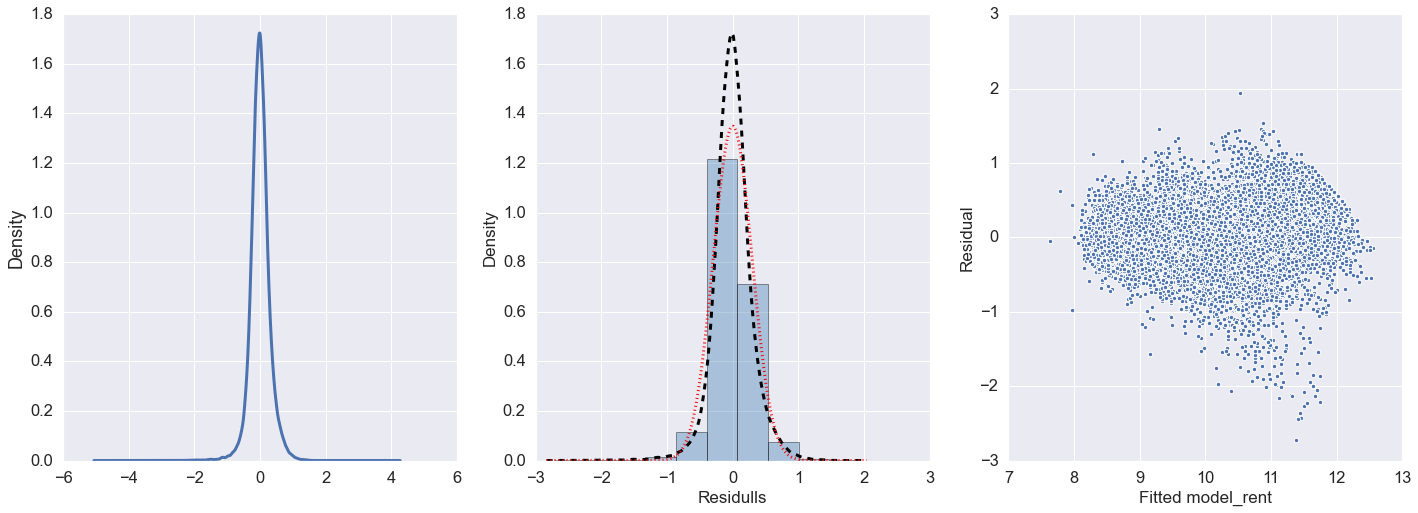

In [189]:
# Fig 5. Residual vs Fitted Plot of model 2.
sns.set(font_scale = 1.5)
f5, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(24, 8))
multi_regression_model_01.resid.plot.density(linewidth=3, ax=ax1)
ax1.set_ylabel('Density')
sns.distplot(a=multi_regression_model_01.resid, bins=10, fit=stats.norm, norm_hist=True, ax=ax2, 
             hist_kws={'color': 'steelblue', 'edgecolor': 'black'},
             kde_kws={'color': 'black', 'linestyle': '--', 'linewidth': 3},
             fit_kws={'color': 'red', 'linestyle': ':', 'linewidth': 3})
ax2.set_ylabel('Density', fontsize=17)
ax2.set_xlabel('Residulls', fontsize=17)
# plt.title('Residual Distribution', fontsize=17)
# plt.scatter(multi_regression_model_2.fittedvalues, multi_regression_model_2.resid)
# plt.xlabel('Fitted model_rent')
# plt.ylabel('Residual')
# plt.title('Residual vs. Fitted Plot of model_rent ')
# plt.savefig('./fig9.jpg')
# plt.show()

# plt.scatter(multi_regression_model_2.fittedvalues, multi_regression_model_2.resid)
# plt.xlabel('Fitted model_rent')
# plt.ylabel('Residual')
# plt.title('Residual vs. Fitted Plot of model_rent ')
# plt.savefig('./Fig 5.Residual vs Fitted Plot of model 2.jpg')
# plt.show()

ax3.scatter(multi_regression_model_01.fittedvalues, multi_regression_model_01.resid)
ax3.set_xlabel('Fitted model_rent', fontsize=17)
ax3.set_ylabel('Residual', fontsize=17)
plt.savefig('./Fig 5.Residual vs Fitted Plot of model 01.jpg')
plt.show()

### PART 4: K-MEANS CLUSTERING

4.1 Make the original and after clustering diagrams.

In [196]:
import sklearn.cluster as sklc
import sklearn.metrics as sklm
from sklearn.cluster import KMeans
from sklearn import model_selection
import statsmodels.api as sm

In [197]:
# Final K-Means clustering on features: size, unit rent, income of second-hand houses.
df_cluster = df[['Size', 'Unit_price','Distance']]
km = KMeans(n_clusters=4, n_init=10)
y_pred = km.fit_predict(df_cluster)

df['clusters'] = km.labels_.tolist()
df['clusters']=df['clusters'].map(lambda x : x+1)

In [198]:
df_cluster['clusters']=df['clusters']
df_cluster.loc[df_cluster.clusters==1]['Unit_price']

6                                       168.4200
22                                      180.7200
31                                      183.6100
46                                      173.1400
49                                      176.6700
                          ...                   
40943                                   236.1700
40944                                   254.4100
40949                                   201.1400
40950                                   177.0400
40952                                   167.7500
Name: Unit_price, Length: 7683, dtype: float64

5.2 Make two variables clustering

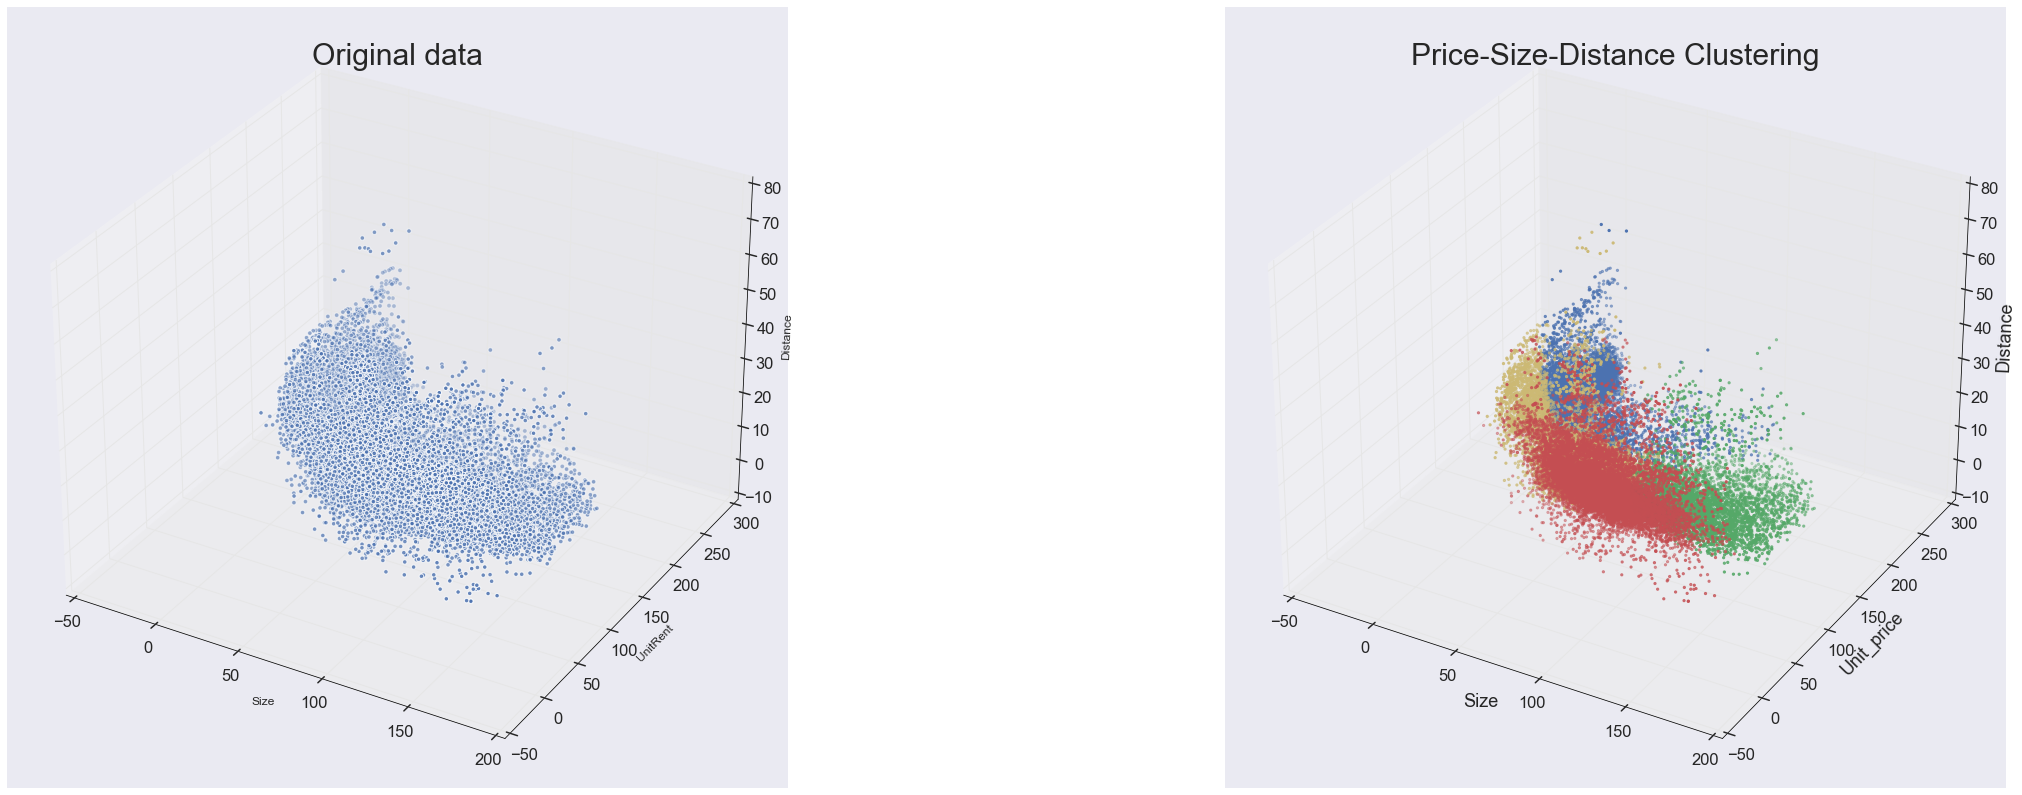

In [199]:
# Fig 6.Original vs Clustering
fig = plt.figure(figsize = (40,14))
ax1 = fig.add_subplot(121,projection='3d')
ax1.scatter(df_cluster['Size'], df_cluster['Unit_price'],df_cluster['Distance'],marker='o')
ax1.set_xlabel('Size', fontsize=12)
ax1.set_ylabel('UnitRent', fontsize=12)
ax1.set_zlabel('Distance', fontsize=12)
ax1.set_title('Original data', fontsize=30)

ax2 = fig.add_subplot(122,projection='3d')
ax2.scatter(df_cluster.loc[df_cluster.clusters==1]['Size'], df_cluster.loc[df_cluster.clusters==1]['Unit_price'],
            df_cluster.loc[df_cluster.clusters==1]['Distance'],label='1',marker='o',color='b',s=5)
ax2.scatter(df_cluster.loc[df_cluster.clusters==2]['Size'], df_cluster.loc[df_cluster.clusters==2]['Unit_price'],
            df_cluster.loc[df_cluster.clusters==2]['Distance'],label='2',marker='o',color='r',s=5)
ax2.scatter(df_cluster.loc[df_cluster.clusters==3]['Size'], df_cluster.loc[df_cluster.clusters==3]['Unit_price'],
            df_cluster.loc[df_cluster.clusters==3]['Distance'],label='3',marker='o',color='y',s=5)
ax2.scatter(df_cluster.loc[df_cluster.clusters==4]['Size'], df_cluster.loc[df_cluster.clusters==4]['Unit_price'],
            df_cluster.loc[df_cluster.clusters==4]['Distance'],label='4',marker='o',color='g',s=5)
ax2.scatter(df_cluster.loc[df_cluster.clusters==5]['Size'], df_cluster.loc[df_cluster.clusters==5]['Unit_price'],
            df_cluster.loc[df_cluster.clusters==5]['Distance'],label='5',marker='o',color='c',s=5)
#ax2.legend()
ax2.set_xlabel('Size', fontsize=18)
ax2.set_ylabel('Unit_price', fontsize=18)
ax2.set_zlabel('Distance', fontsize=18)
ax2.set_title('Price-Size-Distance Clustering', fontsize=30)

plt.savefig('./Fig 6.Original vs Clustering.jpg')
plt.show()

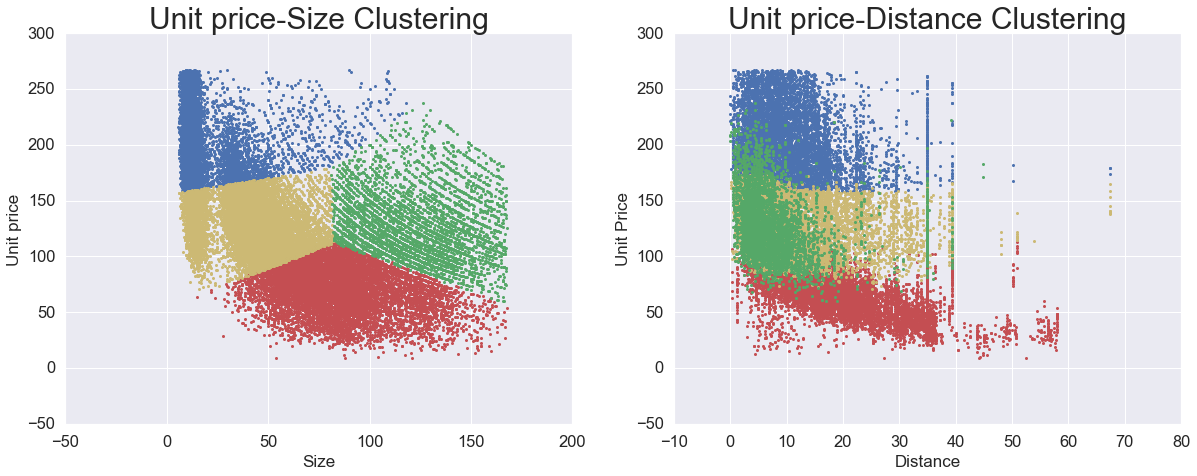

In [200]:
# Fig 7.Two variables Clustering
fig = plt.figure(figsize = (20,7))
ax1 = fig.add_subplot(121)
ax1.scatter(df_cluster.loc[df_cluster.clusters==1]['Size'],df_cluster.loc[df_cluster.clusters==1]['Unit_price'],s=4,
            label='1',marker='o',color='b')
ax1.scatter(df_cluster.loc[df_cluster.clusters==2]['Size'],df_cluster.loc[df_cluster.clusters==2]['Unit_price'],s=4,
            label='2',marker='o',color='r')
ax1.scatter(df_cluster.loc[df_cluster.clusters==3]['Size'],df_cluster.loc[df_cluster.clusters==3]['Unit_price'],s=4,
            label='3',marker='o',color='y')
ax1.scatter(df_cluster.loc[df_cluster.clusters==4]['Size'],df_cluster.loc[df_cluster.clusters==4]['Unit_price'],s=4,
            label='4',marker='o',color='g')
ax1.scatter(df_cluster.loc[df_cluster.clusters==5]['Size'],df_cluster.loc[df_cluster.clusters==5]['Unit_price'],s=4,
            label='5',marker='o',color='c')
#ax1.legend()
ax1.set_ylabel('Unit price', fontsize=17)
ax1.set_xlabel('Size', fontsize=17)
ax1.set_title('Unit price-Size Clustering', fontsize=30)

ax2 = fig.add_subplot(122)

ax2.scatter(df_cluster.loc[df_cluster.clusters==1]['Distance'],df_cluster.loc[df_cluster.clusters==1]['Unit_price'],s=4,
            label='1',marker='o',color='b')
ax2.scatter(df_cluster.loc[df_cluster.clusters==2]['Distance'],df_cluster.loc[df_cluster.clusters==2]['Unit_price'],s=4,
            label='2',marker='o',color='r')
ax2.scatter(df_cluster.loc[df_cluster.clusters==3]['Distance'],df_cluster.loc[df_cluster.clusters==3]['Unit_price'],s=4,
            label='3',marker='o',color='y')
ax2.scatter(df_cluster.loc[df_cluster.clusters==4]['Distance'],df_cluster.loc[df_cluster.clusters==4]['Unit_price'],s=4,
            label='4',marker='o',color='g')
ax2.scatter(df_cluster.loc[df_cluster.clusters==5]['Distance'],df_cluster.loc[df_cluster.clusters==5]['Unit_price'],s=4,
            label='5',marker='o',color='c')
#ax2.legend()
ax2.set_ylabel('Unit Price', fontsize=17)
ax2.set_xlabel('Distance', fontsize=17)
ax2.set_title('Unit price-Distance Clustering', fontsize=30)

plt.savefig('./Fig 7.Two variables Clustering.jpg')
plt.show()